In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.exposure import equalize_adapthist
from skimage.filters import threshold_otsu
from skimage.measure import label, regionprops
from skimage.morphology import remove_small_objects
from feature_extraction import feature_extraction, mask_postprocess

🧬 ecDNA (Red channel)
  - Spot : 19
  - average intensity: 0.72
  - average size: 43.84 pixels

📗 Chromosome (Green channel)
  - Detected chromosome: 1
  - total area: 54.0 pixels
  - total intensity: 46.61
  - average intensity: 0.86


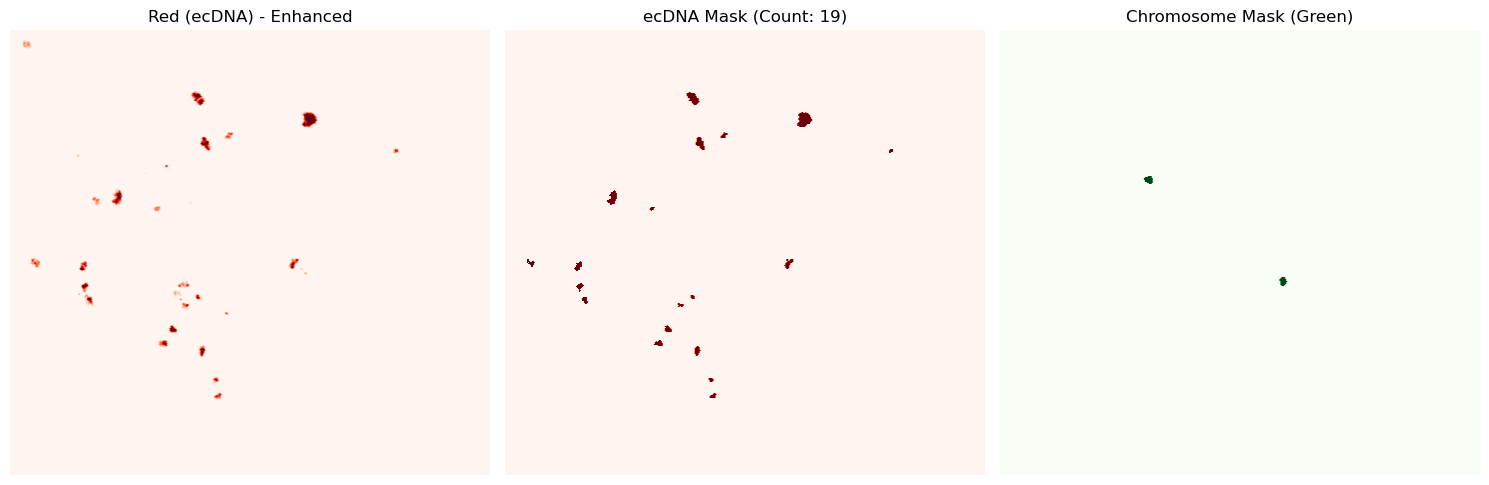

In [15]:
image_path = '231123.Colo320DM.MYC.034.tif'  
image = imread(image_path)

# 🔴 Red (ecDNA) / 🟢 Green (Chromosome) 
red = image[..., 0]
green = image[..., 1]

red_eq = equalize_adapthist(red)
green_eq = equalize_adapthist(green)

thresh_r = threshold_otsu(red_eq)
thresh_g = threshold_otsu(green_eq)

red_binary = red_eq > thresh_r
red_cleaned = remove_small_objects(red_binary, min_size=10)

green_binary = green_eq > thresh_g

def extract_red_ecdna_features(red_image, mask, min_size=10):
    labeled = label(mask)
    props = regionprops(labeled, intensity_image=red_image)

    count = 0
    total_intensity = 0
    total_area = 0

    for r in props:
        if r.area >= min_size:
            count += 1
            total_intensity += r.mean_intensity * r.area
            total_area += r.area

    mean_intensity = total_intensity / total_area if total_area else 0
    mean_size = total_area / count if count else 0
    return count, mean_intensity, mean_size

def extract_green_chromosome_features(green_image, mask):
    labeled = label(mask)
    props = regionprops(labeled, intensity_image=green_image)

    if not props:
        return 0, 0, 0, 0  

    largest = max(props, key=lambda r: r.area)
    total_intensity = largest.mean_intensity * largest.area
    area = largest.area
    mean_intensity = largest.mean_intensity

    return 1, total_intensity, area, mean_intensity

r_comp, r_mean_inten, r_mean_size = extract_red_ecdna_features(red_eq, red_cleaned)
g_comp, g_total_inten, g_area, g_mean_inten = extract_green_chromosome_features(green_eq, green_binary)

print("🧬 ecDNA (Red channel)")
print(f"  - Spot : {r_comp}")
print(f"  - average intensity: {r_mean_inten:.2f}")
print(f"  - average size: {r_mean_size:.2f} pixels")

print("\n📗 Chromosome (Green channel)")
print(f"  - Detected chromosome: {g_comp}")
print(f"  - total area: {g_area} pixels")
print(f"  - total intensity: {g_total_inten:.2f}")
print(f"  - average intensity: {g_mean_inten:.2f}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(red_eq, cmap='Reds')
axs[0].set_title("Red (ecDNA) - Enhanced")

axs[1].imshow(red_cleaned, cmap='Reds')
axs[1].set_title(f"ecDNA Mask (Count: {r_comp})")

axs[2].imshow(green_binary, cmap='Greens')
axs[2].set_title("Chromosome Mask (Green)")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [16]:
def chromosome_features_dbscan(image, mask_chrom, eps_distance=6, closing_radius=2):
    from skimage.morphology import binary_closing, disk
    from scipy.ndimage import binary_fill_holes
    from skimage.measure import label, regionprops
    from sklearn.cluster import DBSCAN
    import numpy as np

    mask_filled = binary_fill_holes(mask_chrom)
    mask_closed = binary_closing(mask_filled, disk(closing_radius))

    labeled = label(mask_closed, connectivity=2)
    props = regionprops(labeled, intensity_image=image[..., 1])
    if len(props) == 0:
        return 0, 0, 0, 0

    centroids = np.array([p.centroid for p in props])

    clustering = DBSCAN(eps=eps_distance, min_samples=1).fit(centroids)
    chrom_count = len(set(clustering.labels_))

    total_area = sum(p.area for p in props)
    total_intensity = sum(p.intensity_image.sum() for p in props)
    mean_intensity = total_intensity / total_area if total_area > 0 else 0

    return chrom_count, total_intensity, total_area, mean_intensity

In [13]:
# image_dir = 'COLO320HSR'
# output_csv = 'COLO320HSR_metaphase_feature_results_v5.csv'
image_dir = 'COLO320DM'
output_csv = 'COLO320DM_metaphase_feature_results_v5.csv'

results = []

for filename in sorted(os.listdir(image_dir)):
    if filename.endswith('.tif'):
        image_path = os.path.join(image_dir, filename)
        image = imread(image_path)

        red = image[..., 0]
        green = image[..., 1]

        thresh_r = threshold_otsu(red)
        thresh_g = threshold_otsu(green)

        mask_ecDNA = remove_small_objects(red > thresh_r, 10)
        mask_chrom = remove_small_objects(green > thresh_g, 10)

        mask = np.zeros_like(red, dtype=np.uint8)
        mask[mask_chrom] = 2
        mask[mask_ecDNA] = 3

        mask_pp = mask_postprocess(mask.copy())

        # 🔴 ecDNA feature 
        features = feature_extraction(image, mask_pp)
        r_comp, _, r_inten, _, r_size, _, _, _ = features[8:16]

        # 🟢 Chromosome feature 
        g_comp, g_total_inten, g_area, g_mean_inten = chromosome_features_dbscan(image, mask_chrom)

        # 🧮 ecDNA per cell (2 chromosome = 1 cell)
        est_cell_count = g_comp / 2 if g_comp > 0 else np.nan
        ecDNA_per_cell = r_comp / est_cell_count if est_cell_count else np.nan

        results.append([
            filename,
            ecDNA_per_cell,
            r_comp, g_comp,
            r_inten, g_total_inten,
            r_size, g_area,
            g_comp, g_mean_inten
        ])


columns = [
    'image_name', 'ecDNA_per_cell',
    'metaphase_r_comp', 'metaphase_g_comp',
    'metaphase_r_inten', 'metaphase_g_inten',
    'metaphase_r_size', 'metaphase_g_size',
    'metaphase_chrom_num', 'metaphase_mean_chrom_inten'
]

df = pd.DataFrame(results, columns=columns)
# df.to_csv(output_csv, index=False)
print(f"✅ compele: saved as {output_csv}")


✅ compele: saved as COLO320DM_metaphase_feature_results_v5.csv


# Counts


In [17]:
ecCount_dm=pd.read_csv('COLO320DM_metaphase_feature_results_v5.csv')
ecCount_hsr=pd.read_csv('COLO320HSR_metaphase_feature_results_v5.csv')

print(ecCount_dm.shape, ecCount_hsr.shape)

(53, 10) (12, 10)


In [18]:
ecCount_dm.head(2)

,image_name,ecDNA_per_cell,metaphase_r_comp,metaphase_g_comp,metaphase_r_inten,metaphase_g_inten,metaphase_r_size,metaphase_g_size,metaphase_chrom_num,metaphase_mean_chrom_inten
0,231123.Colo320DM.MYC.033.tif,32.666667,49.0,3,109.134618,182630.0,84.591837,938.0,3,194.701493
1,231123.Colo320DM.MYC.034.tif,23.000000,23.0,2,118.025964,23123.0,61.739130,103.0,2,224.495146


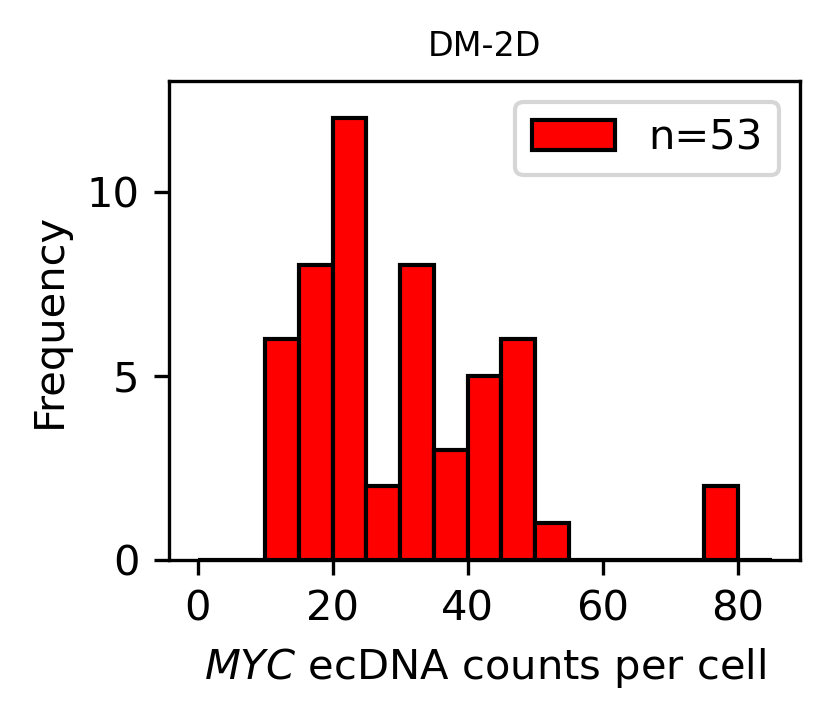

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 2.5), dpi=300)
n_bins = 10
bins = range(0, 90, 5)
ymax = 13

plt.hist(ecCount_dm['ecDNA_per_cell'], bins=bins, color='red', edgecolor='black')
plt.xlabel(r'$\it{MYC}$ ecDNA counts per cell')
plt.ylabel('Frequency')
plt.title('DM-2D',size=8)
plt.ylim(0, ymax)  

sample_count = ecCount_dm.shape[0]
plt.legend([f'n={sample_count}'])

plt.tight_layout()
# plt.savefig("ecDNA_counts_DM_2D_counts.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()



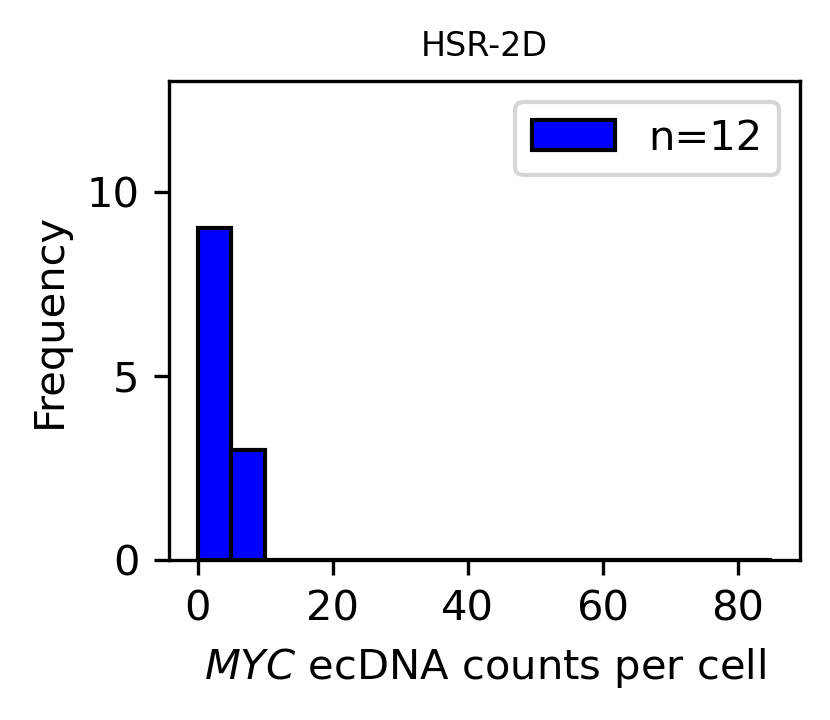

In [20]:
plt.figure(figsize=(3, 2.5), dpi=300)

bins = range(0, 90, 5)
ymax=13

plt.hist(ecCount_hsr['ecDNA_per_cell'], bins=bins, color='blue', edgecolor='black')
plt.xlabel(r'$\it{MYC}$ ecDNA counts per cell')
plt.ylabel('Frequency')
plt.title('HSR-2D',size=8)
plt.ylim(0, ymax)  

sample_count = ecCount_hsr.shape[0]
plt.legend([f'n={sample_count}'])

plt.tight_layout()
# plt.savefig("ecDNA_counts_HSR_2D_counts.png", dpi=300, bbox_inches='tight', transparent=True)

plt.show()

